In [1]:
# 'unicode_escape -*-
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.api import anova_lm
import matplotlib.pyplot as plt
import pandas as pd
from patsy import dmatrices
import itertools as it
import random

In [2]:
# Load data 读取数据
df = pd.read_csv(r"D:\desktop\2023\statistics\NFL.csv"
                 
                ,encoding= 'unicode_escape')


#拆分为训练集和验证集
dftest=df.iloc[int(len(df)*0.75):,:]#验证集,24个样本
df=df.iloc[:int(len(df)*0.75),:]#训练集，
variate = set(df.columns)  #获取列名
variate.remove('Rating')  #去除无关列
variate.remove('Name')
variate.remove('Team')


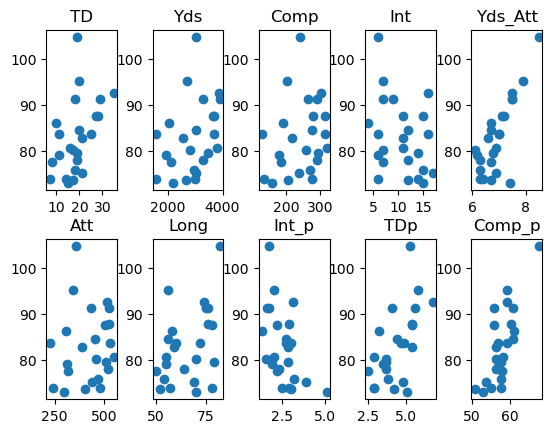

In [3]:
#散点图
fig, axs = plt.subplots(2, 5)
plt.subplots_adjust(wspace =0.5, hspace =0.3)
#plt.scatter(np.array(df.iloc[:,'Att']),np.array(df.iloc[:,'Rating']))
for i,idx in enumerate([*variate]):
    if i<5:
        axs[0, i].scatter((np.array(df[[idx]])), (np.array(df[['Rating']])))
        axs[0, i].set_title(idx)
    else:
        axs[1, i-5].scatter((np.array(df[[idx]])), (np.array(df[['Rating']])))
        axs[1, i-5].set_title(idx)

In [4]:
#定义多个数组，用来分别用来添加变量，删除变量
x = []
variate_add = []
variate_del = variate.copy()
# print(variate_del)
y = ['Yds_Att','TD','TDp','Int_p','Yds','Comp_p'] #根据散点图选择6个变量
#将随机生成的三个变量分别输入到 添加变量和删除变量的数组
for i in y:
    variate_add.append(i)
    x.append(i)
    variate_del.remove(i)
global aic   #设置全局变量 这里选择AIC值作为指标
formula="{}~{}".format("Rating","+".join(variate_add))  #将自变量名连接起来
print(formula)
aic=smf.ols(formula=formula,data=df).fit().aic  #获取随机函数的AIC值，与后面的进行对比
print("初始化选模型为：{}~{}，对应的AIC值为：{}".format("y","+".join(variate_add), aic))
print("\n")


Rating~Yds_Att+TD+TDp+Int_p+Yds+Comp_p
初始化选模型为：y~Yds_Att+TD+TDp+Int_p+Yds+Comp_p，对应的AIC值为：-9.455436015078241




In [5]:
#添加变量
def forward():
    score_add = []
    global best_add_score
    global best_add_c
    print("添加变量")
    for c in variate_del:
        formula = "{}~{}".format("Rating", "+".join(variate_add+[c]))
        score = smf.ols(formula = formula, data = df).fit().aic
        score_add.append((score, c))   #将添加的变量，以及新的AIC值一起存储在数组中
        
        print('自变量为{}，对应的AIC值为：{}'.format("+".join(variate_add+[c]), score))

    score_add.sort(reverse=True)  #对数组内的数据进行排序，选择出AIC值最小的
    best_add_score, best_add_c = score_add.pop()
    
    print("最小AIC值为：{}".format(best_add_score))
    print("\n")

In [6]:
#删除变量
def back():
    score_del = []
    global best_del_score
    global best_del_c
    print("剔除变量")
    for i in x:

        select = x.copy() #copy一个集合，避免重复修改到原集合
        select.remove(i)
        formula = "{}~{}".format("Rating","+".join(select))
        score = smf.ols(formula = formula, data = df).fit().aic
        print('自变量为{}，对应的AIC值为：{}'.format("+".join(select), score))
        score_del.append((score, i))

    score_del.sort(reverse=True) #排序，方便将最小值输出
    best_del_score, best_del_c = score_del.pop()  #将最小的AIC值以及对应剔除的变量分别赋值
    print("最小AIC值为：{}".format(best_del_score))
    print("\n")

print("剩余变量为：{}".format(variate_del))

剩余变量为：{'Comp', 'Int', 'Att', 'Long'}


In [7]:
forward()
back()
while variate:
      
#     forwark()
#     back()
    if(aic < best_add_score < best_del_score or aic < best_del_score < best_add_score):
        print("当前回归方程为最优回归方程，为{}~{}，AIC值为：{}".format("y","+".join(variate_add), aic))
        break
    elif(best_add_score < best_del_score < aic or best_add_score < aic < best_del_score):
        print("目前最小的aic值为{}".format(best_add_score))
        print('选择自变量：{}'.format("+".join(variate_add + [best_add_c])))   
        print('\n')
        variate_del.remove(best_add_c)
        variate_add.append(best_add_c)
        print("剩余变量为：{}".format(variate_del))
        aic = best_add_score
        forward()
    else:
        print('当前最小AIC值为：{}'.format(best_del_score))
        print('需要剔除的变量为：{}'.format(best_del_c))
        aic = best_del_score   #将AIC值较小的选模型AIC值赋给aic再接着下一轮的对比
        x.remove(best_del_c)  #在原集合上剔除选模型所对应剔除的变量
        back()

添加变量
自变量为Yds_Att+TD+TDp+Int_p+Yds+Comp_p+Comp，对应的AIC值为：-11.844075964661293
自变量为Yds_Att+TD+TDp+Int_p+Yds+Comp_p+Int，对应的AIC值为：-10.444827775958565
自变量为Yds_Att+TD+TDp+Int_p+Yds+Comp_p+Att，对应的AIC值为：-13.180835709366171
自变量为Yds_Att+TD+TDp+Int_p+Yds+Comp_p+Long，对应的AIC值为：-8.05317836776728
最小AIC值为：-13.180835709366171


剔除变量
自变量为TD+TDp+Int_p+Yds+Comp_p，对应的AIC值为：78.5091749603557
自变量为Yds_Att+TDp+Int_p+Yds+Comp_p，对应的AIC值为：-11.453270392090552
自变量为Yds_Att+TD+Int_p+Yds+Comp_p，对应的AIC值为：57.66343619621462
自变量为Yds_Att+TD+TDp+Yds+Comp_p，对应的AIC值为：128.5249745029637
自变量为Yds_Att+TD+TDp+Int_p+Comp_p，对应的AIC值为：-11.45135687142362
自变量为Yds_Att+TD+TDp+Int_p+Yds，对应的AIC值为：114.33298098636394
最小AIC值为：-11.453270392090552


目前最小的aic值为-13.180835709366171
选择自变量：Yds_Att+TD+TDp+Int_p+Yds+Comp_p+Att


剩余变量为：{'Comp', 'Int', 'Long'}
添加变量
自变量为Yds_Att+TD+TDp+Int_p+Yds+Comp_p+Att+Comp，对应的AIC值为：-11.344960480179545
自变量为Yds_Att+TD+TDp+Int_p+Yds+Comp_p+Att+Int，对应的AIC值为：-12.121363643482248
自变量为Yds_Att+TD+TDp+Int_p+Yds+Comp_p+Att+Long，对应的A

In [8]:
#跟据逐步回归选取出的变量，进行线性回归
X=df[['Comp_p','TD','Att','Yds_Att','TDp','Int_p','Yds']]
X['Beta0']=1
Rating=df[['Rating']]
X.head(),Rating.head(),type(X)

C:\Users\0.0\AppData\Local\Temp\ipykernel_6340\3282034745.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Beta0']=1


(   Comp_p  TD  Att  Yds_Att  TDp  Int_p   Yds  Beta0
 0    67.7  19  356      8.5  5.3    1.7  3029      1
 1    59.1  20  342      7.9  5.8    2.0  2692      1
 2    59.3  35  513      7.5  6.8    3.1  3867      1
 3    60.7  18  435      7.5  4.1    1.6  3281      1
 4    55.7  29  521      7.5  5.6    1.7  3917      1,
    Rating
 0   104.7
 1    95.1
 2    92.6
 3    91.2
 4    91.2,
 pandas.core.frame.DataFrame)

In [9]:
res=np.linalg.lstsq(X,Rating,rcond=None)
res

(array([[ 8.61323675e-01],
        [-6.87932838e-02],
        [-1.43843216e-02],
        [ 3.23769147e+00],
        [ 3.54660999e+00],
        [-4.02699296e+00],
        [ 2.49069724e-03],
        [ 5.74786259e+00]]),
 array([0.4165739]),
 8,
 array([1.48246552e+04, 1.61525475e+02, 6.38149947e+01, 1.71677438e+01,
        4.30457112e+00, 1.62477211e+00, 6.65166466e-01, 6.05328800e-02]))

In [15]:
Beta=res[0]
print("回归方程为Rating={}+{}*Comp_p+{}*TD+{}*Att+{}*Yds_Att+{}*TDp+{}*Int_p+{}*Yds".format(Beta[7],\
     Beta[0],Beta[1],Beta[2],Beta[3],Beta[4],Beta[5],Beta[6]))

回归方程为Rating=[5.74786259]+[0.86132367]*Comp_p+[-0.06879328]*TD+[-0.01438432]*Att+[3.23769147]*Yds_Att+[3.54660999]*TDp+[-4.02699296]*Int_p+[0.0024907]*Yds


In [16]:
#验证集验证模型，计算残差平方和
Xtest=dftest[['Comp_p','TD','Att','Yds_Att','TDp','Int_p','Yds']]
Xtest['Beta0']=1
Xtest=np.array(Xtest)
Ytest=np.array(dftest[['Rating']])
R_square=np.sum((np.square((np.dot(Xtest,Beta)-Ytest))))
print("\n在验证集上的残差平方和为：\n",R_square)


在验证集上的残差平方和为：
 0.832287667930125


C:\Users\0.0\AppData\Local\Temp\ipykernel_6340\1388849265.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xtest['Beta0']=1
